In [1]:
import pandas as pd
from torch import optim
import torch
import matplotlib.pyplot as plt
import warnings
import numpy as np
import random
warnings.filterwarnings("ignore")

from dataloader import getDNNData, getUnscaledData
from models import ArbFreeDNN, train_DNN, eval_DNN, getModels

In [2]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 120
LAYERS = [128, 128, 128, 128]
ARB_MULT = 1.0

Epoch: 0 | Progress: 0.00| Loss: 0.035537 | Time Elapsed: 0.00 min
Epoch: 0 | Progress: 0.04| Loss: 0.019272 | Time Elapsed: 0.00 min
Epoch: 0 | Progress: 0.08| Loss: 0.001271 | Time Elapsed: 0.01 min
Epoch: 0 | Progress: 0.13| Loss: 0.000554 | Time Elapsed: 0.01 min
Epoch: 0 | Progress: 0.17| Loss: 0.001874 | Time Elapsed: 0.01 min
Epoch: 0 | Progress: 0.21| Loss: 0.015116 | Time Elapsed: 0.02 min
Epoch: 0 | Progress: 0.25| Loss: 0.004728 | Time Elapsed: 0.02 min
Epoch: 0 | Progress: 0.29| Loss: 0.017560 | Time Elapsed: 0.02 min
Epoch: 0 | Progress: 0.34| Loss: 0.001444 | Time Elapsed: 0.03 min
Epoch: 0 | Progress: 0.38| Loss: 0.003728 | Time Elapsed: 0.03 min
Epoch: 0 | Progress: 0.42| Loss: 0.006152 | Time Elapsed: 0.03 min
Epoch: 0 | Progress: 0.46| Loss: 0.002202 | Time Elapsed: 0.04 min
Epoch: 0 | Progress: 0.50| Loss: 0.010438 | Time Elapsed: 0.04 min
Epoch: 0 | Progress: 0.54| Loss: 0.006676 | Time Elapsed: 0.04 min
Epoch: 0 | Progress: 0.59| Loss: 0.007181 | Time Elapsed: 0.05

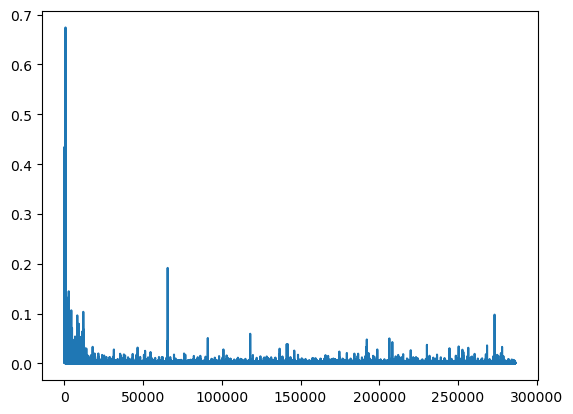

In [5]:
DNN = ArbFreeDNN(layers=LAYERS)
optimizer = optim.Adam(DNN.parameters(), lr=LEARNING_RATE)
dnn_data = getDNNData(section='train', scale=True, ivs_path='data/R2_STD_IVS_DFW_SORTED.pkl', batch_size=1, scaler_id=DNN.getID())
loss_train, re_loss_train, cal_loss_train, but_loss_train = train_DNN(num_epochs=NUM_EPOCHS, model=DNN, train_dataloader=dnn_data, optimizer=optimizer, logging_interval=100, arb_mult=ARB_MULT)
plt.plot(loss_train)
plt.show()

In [10]:
rmse_loss = pd.DataFrame(re_loss_train)
rmse_loss['test']

,0
0,0.207247
1,0.202880
2,0.198941
3,0.206184
4,0.213493
...,...
286435,0.000294
286436,0.000463
286437,0.000110
286438,0.000390


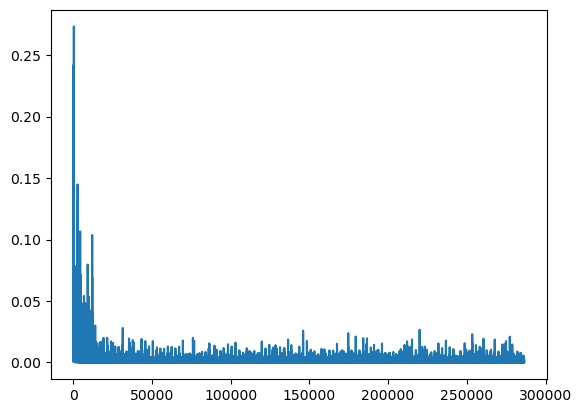

In [10]:
plt.plot(re_loss_train)

In [18]:
re = pd.DataFrame(but_loss_train)
re.columns = ['Train']
re.index = re.index / 2387
re

,Train
0.000000,0.0
0.000419,0.0
0.000838,0.0
0.001257,0.0
0.001676,0.0
...,...
119.997905,0.0
119.998324,0.0
119.998743,0.0
119.999162,0.0


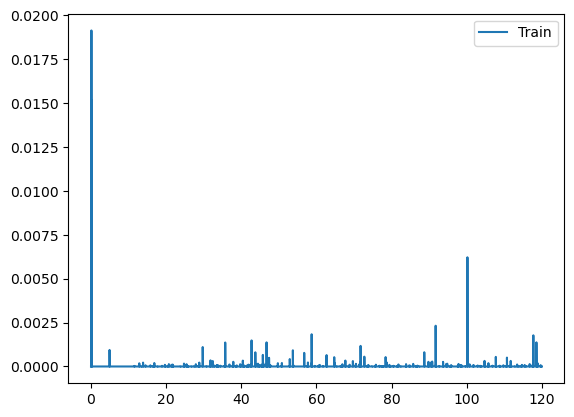

In [19]:
plt.plot(re, label='Train')
plt.legend()
plt.show()

In [8]:
for feature, target in dnn_data:
    feature.requires_grad = True
    print(feature[:, -1].requires_grad)
    print(target.shape)
    break

True
torch.Size([1, 121])


RE AVG: 0.026966180830538013


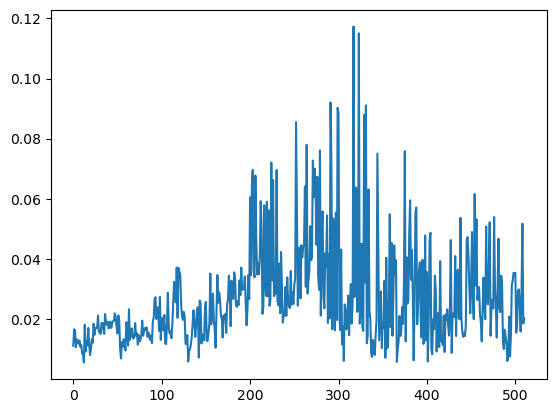

CAL AVG: 0.0


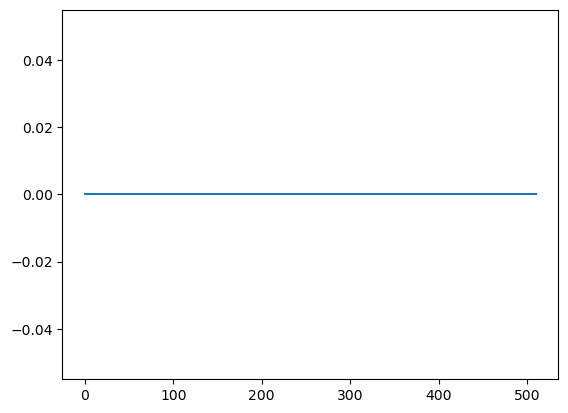

BUT AVG: 1.7889896051187266e-08


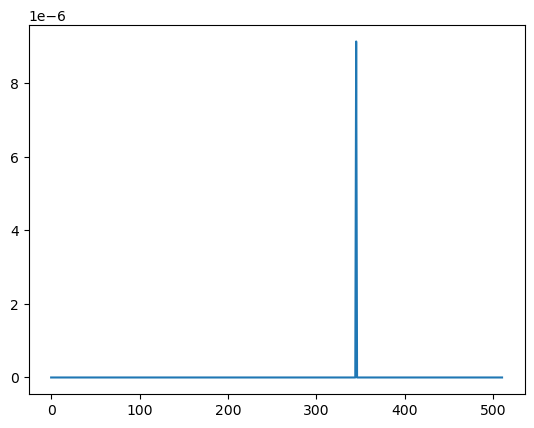

In [9]:
valid_data = getDNNData(section='test', scale=True, batch_size=1, scaler_id=DNN.getID())
re_chart, cal_chart, but_chart = eval_DNN(DNN, valid_data)

print(f'RE AVG: {np.array(re_chart).mean()}')
plt.plot(re_chart)
plt.show()

print(f'CAL AVG: {np.array(cal_chart).mean()}')
plt.plot(cal_chart)
plt.show()

print(f'BUT AVG: {np.array(but_chart).mean()}')
plt.plot(but_chart)
plt.show()

scores = pd.read_csv('model_scores/DNN.csv')
entry = pd.DataFrame()
entry['LAYERS'] = [LAYERS]
entry['LR'] = LEARNING_RATE
entry['NUM_EPOCHS'] = NUM_EPOCHS
entry['ARB_MULT'] = ARB_MULT
entry['NUM_LAYERS'] = len(LAYERS)
entry['MEAN_RE_LOSS'] = np.array(re_chart).mean()
entry['STD_RE_LOSS'] = np.array(re_chart).std()
entry['RE_RATIO'] = np.array(re_chart).mean() / np.array(re_chart).std()
entry['MEAN_CAL_LOSS'] = np.array(cal_chart).mean()
entry['STD_CAL_LOSS'] = np.array(cal_chart).std()
entry['CAL_RATIO'] = np.array(cal_chart).mean() / np.array(cal_chart).std()
entry['MEAN_BUT_LOSS'] = np.array(but_chart).mean()
entry['STD_BUT_LOSS'] = np.array(but_chart).std()
entry['BUT_RATIO'] = np.array(but_chart).mean() / np.array(but_chart).std()
entry['FULL'] = True
entry['ID#'] = DNN.getID()
scores = pd.concat([scores, entry], axis=0).reset_index().drop(columns=['index', 'Unnamed: 0'])
scores.to_csv('model_scores/DNN.csv')

torch.save(DNN.state_dict(), f'all_models/DNN_{DNN.getID()}.pt')

In [19]:
compressed = []
count = 0
curr_sum = 0.0
for item in cal_loss_train:
    if count == 560:
        compressed.append(curr_sum / 560)
        curr_sum = 0.0
        count = 0
    else:
        count += 1
        curr_sum += item

In [22]:
len(cal_loss_train) / 2387

120.0

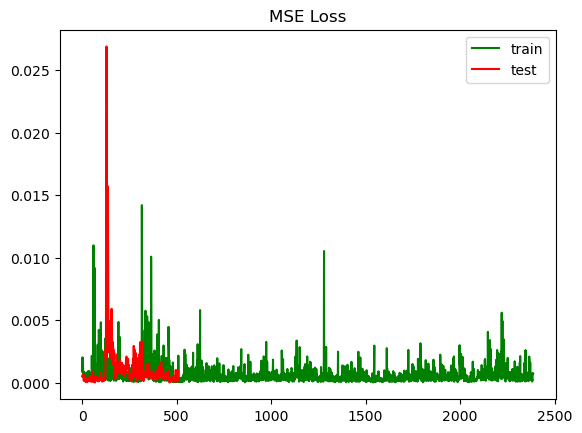

In [35]:
plt.plot(re_loss_train[-2387:], color='g', label='train')
plt.plot(re_chart, color='r', label='test')
plt.legend()
plt.title('MSE Loss')
plt.show()

RE AVG: 0.0279720106423906


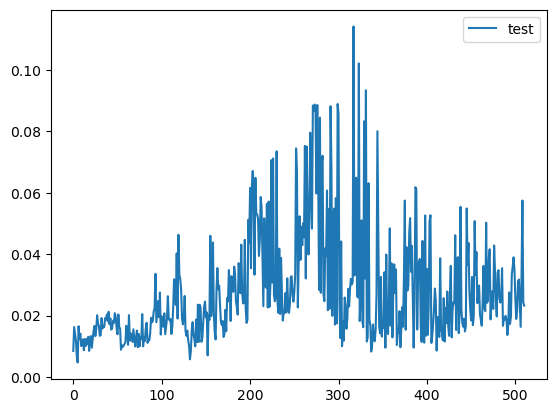

CAL AVG: 0.0


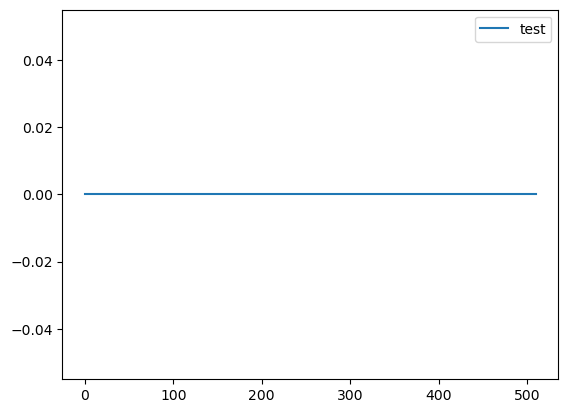

BUT AVG: 9.496610847127727e-10


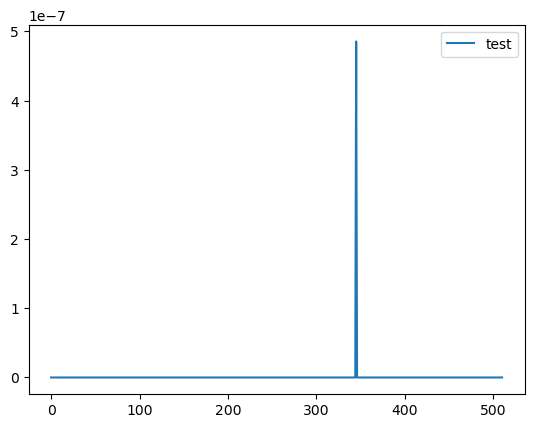

In [4]:
_, _, DNN = getModels('127582', '8125458', '3951028')

valid_data = getDNNData(section='test', scale=True, batch_size=1, scaler_id=DNN.getID())
re_chart, cal_chart, but_chart = eval_DNN(DNN, valid_data)

print(f'RE AVG: {np.array(re_chart).mean()}')
plt.plot(re_chart, label='test')
plt.legend()
plt.show()

print(f'CAL AVG: {np.array(cal_chart).mean()}')
plt.plot(cal_chart, label='test')
plt.legend()
plt.show()

print(f'BUT AVG: {np.array(but_chart).mean()}')
plt.plot(but_chart, label='test')
plt.legend()
plt.show()